# Assignment 1
I'll start by including some of the libraries I'll be needing throughout this

In [1]:
using Roots,QuantEcon,NLsolve,Parameters,Gadfly,DataFrames,LinearAlgebra,Cairo,Fontconfig #Need these last two for Gadfly to produce png
set_default_plot_size(40cm,20cm)
Gadfly.push_theme(Theme(major_label_font_size=20pt,minor_label_font_size=14pt,key_label_font_size=16pt,
                        line_width=2pt,point_size=3pt))

#### Problem 1
Taking first order conditions of the social planners problem and imposing the steady state
gives the following three equations
$$
\begin{align}
1&=\beta[1-\delta+\alpha k^{\alpha-1}h^{1-\alpha}]\\
\frac{1-\theta}{1-h}&=(1-\alpha)k^\alpha h^{-\alpha}\frac\theta{c}\\
c&=Ak^\alpha h^{1-\alpha}-\delta k
\end{align}
$$
Our calibration sets $\beta=0.98$ and $\alpha=0.3$ then targets $\frac{\bar i}{\bar y}=0.16$ and $\bar h=0.3$.
We can acheive this by noting
$$
0.16 =\frac{\bar i}{\bar y}=\frac{\delta\bar k}{\bar k^\alpha \bar h^{1-\alpha}}=\frac{\delta}{\bar k^{\alpha-1}\bar h^{1-\alpha}}
$$
Plugging this into equation 1 we find that
$$
\delta = \frac{\frac1\beta -1}{\frac{\alpha}{0.16}-1}
$$
and
$$
\bar k = \left(\frac{\delta}{0.16\bar h^{1-\alpha}}\right)^\frac{1}{\alpha-1}.
$$
Finally we have that 
$$
\bar c = A\bar k^\alpha\bar h^{1-\alpha}-\delta\bar k
$$
and
$$
\theta = \left(1+(1-\bar h)(1-\alpha)\bar k^\alpha \bar h^{-\alpha}\frac1c\right)^{-1}.
$$
This is implemented in the code bellow `RBCmodelNS()` constructs and instance of `RBCmodelNS` using this procedure 
to calibrate the parameters

In [2]:
@with_kw mutable struct RBCmodelNS
    β::Float64 
    α::Float64 
    θ::Float64 
    δ::Float64 

    #steady state
    h̄::Float64 
    ī::Float64
    k̄::Float64
    c̄::Float64

    #objects for Bellman equation
    kgrid::Vector{Float64} = zeros(0)
    U::Matrix{Float64} = zeros(0,0)
    h::Matrix{Float64} = zeros(0,0)
end

"""
    RBCmodelNS()

Constructs RBCmodelNS based on calibration and stores steady state
"""
function RBCmodelNS()
    β = 0.98
    α = 0.3
    #first compute steady state
    h̄ = 0.3
    δ = (1/β-1)/(α/0.16 - 1)
    k̄ = (δ/0.16*0.3^(α-1))^(1/(α-1))
    c̄ = k̄^α*h̄^(1-α)-δ*k̄
    θ = (1 + (1-h̄)*(1-α)*k̄^α*h̄^(-α)/c̄)^(-1)
    ī = δ*k̄
    return RBCmodelNS(β=β,α=α,θ=θ,δ=δ,h̄=h̄,ī=ī,k̄=k̄,c̄=c̄)
end;
model = RBCmodelNS()
println(model.θ)
println(model.δ)

0.339622641509434
0.02332361516034988


#### Problem 2
We'll approach this problem by solving the system of equations for the path ${k_t}_{t=1}^T$ where
it is assumed we have converged to the steady state after $T$ periods.  We'll solve jointly for the
path of investment and labor ${i_t,h_t}_{t=1}^T$ (this latter will allow us to easily implement $i_t\geq0$).
Given this path the following equations must be satisfied
$$
\begin{align}
    \frac{\theta}{c_t} &= \beta R_{t+1}\frac{\theta}{c_{t+1}}\\
    \frac{1-\theta}{1-h_t} &= \frac{\theta}{c_t}(1-\alpha)k_t^\alpha h_t^{-\alpha}
\end{align}
$$
where $R_t = 1-\delta+\alpha k_t^{\alpha-1} h_t^{1-\alpha}$.  I've implemented this in the following code

In [3]:
"""
    path_residuals(model::RBCmodelNS,k0::Float64,ihpath)

compute residuals given a path of i and h
"""
function path_residuals!(model::RBCmodelNS,k0::Float64,res,ihpath,T)
    @unpack α,β,δ,θ,k̄,h̄,c̄ = model
    ipath,hpath = ihpath[1:T],ihpath[T+1:end]
    k = zeros(T+2)
    k[1] = k0
    for t in 1:T
        k[t+1] = (1-δ)*k[t] + ipath[t] 
    end
    k[T+2] = k̄
    h = [hpath;h̄]
    #compute path of c given guess of $k$
    c = [k[t]^α*h[t]^(1-α) + (1-δ)*k[t] - k[t+1] for t in 1:T+1]
    u_c = @. θ/c
    u_n = @. (1-θ)/(1 - h)
    F_n = @. (1-α)*k[1:T+1]^α*h^(-α)
    R = @. 1-δ+α*k[1:T+1]^(α-1)*h^(1-α)

    res[1:T] .= u_c[1:T].-β.*R[2:T+1].*u_c[2:T+1]
    res[T+1:end] .= u_c[1:T].*F_n[1:T].-u_n[1:T]
end;

`path_residuals!` takes a guess of the path of $i_t$ and $h_t$ stacked together and returns
the stacked residuals of the Euler equation and labor leisure choice (this ordering will be important 
later).  We then need to wrap this in a solver to return the solution

In [4]:
"""
    solve_transition(model::RBCmodelNS,k0,T)
    
returns a path of 
"""
function solve_transition(model::RBCmodelNS,k0,T)
    @unpack α,β,δ,θ,k̄,h̄,c̄ = model
    f!(F,x) = path_residuals!(model,k0,F,x,T)
    ihpath0 = [model.ī*ones(T);model.h̄*ones(T)]

    res = nlsolve(f!,ihpath0)

    if !converged(res)
        error("Could not find root")
    end
    #Now back out aggregates
    ihpath = res.zero
    ipath,hpath = ihpath[1:T],ihpath[T+1:end]
    k = zeros(T+2)
    k[1] = k0
    for t in 1:T
        k[t+1] = (1-δ)*k[t] + ipath[t] 
    end
    k[T+2] = k̄
    h = [hpath;h̄]
    #compute path of c given guess of $k$
    c = [k[t]^α*h[t]^(1-α) + (1-δ)*k[t] - k[t+1] for t in 1:T+1]
    y = [k[t]^α*h[t]^(1-α) for t in 1:T+1]
    return DataFrame(k=k[1:T],c=c[1:T],h=h[1:T],i=ipath,y=y[1:T])
end;

Here's the path of capital, consumption, hours and investment if capital starts out 
above the steady state

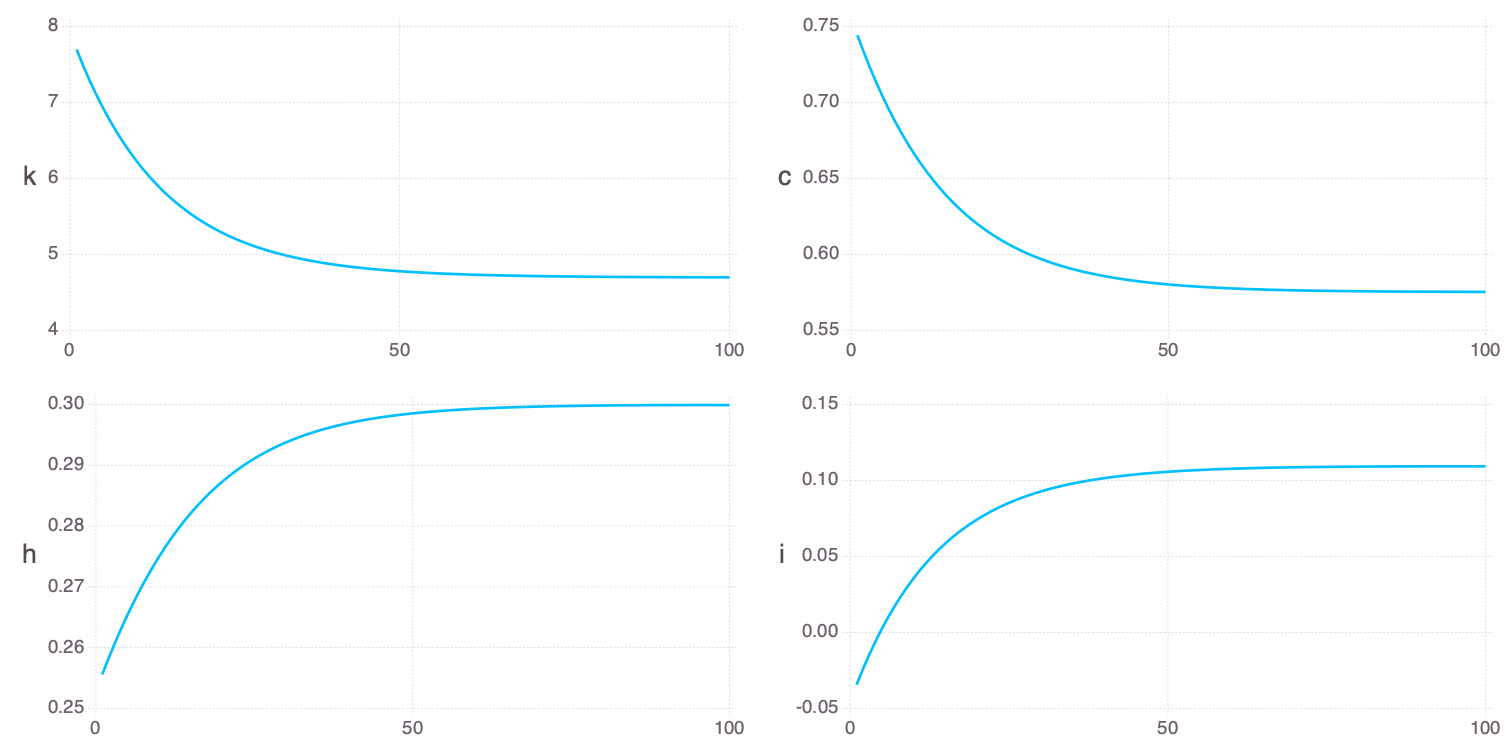

In [5]:
df = solve_transition(model,model.k̄+3,100)
gridstack([plot(df,y=:k,Geom.line) plot(df,y=:c,Geom.line);plot(df,y=:h,Geom.line) plot(df,y=:i,Geom.line)])

and below the steady state

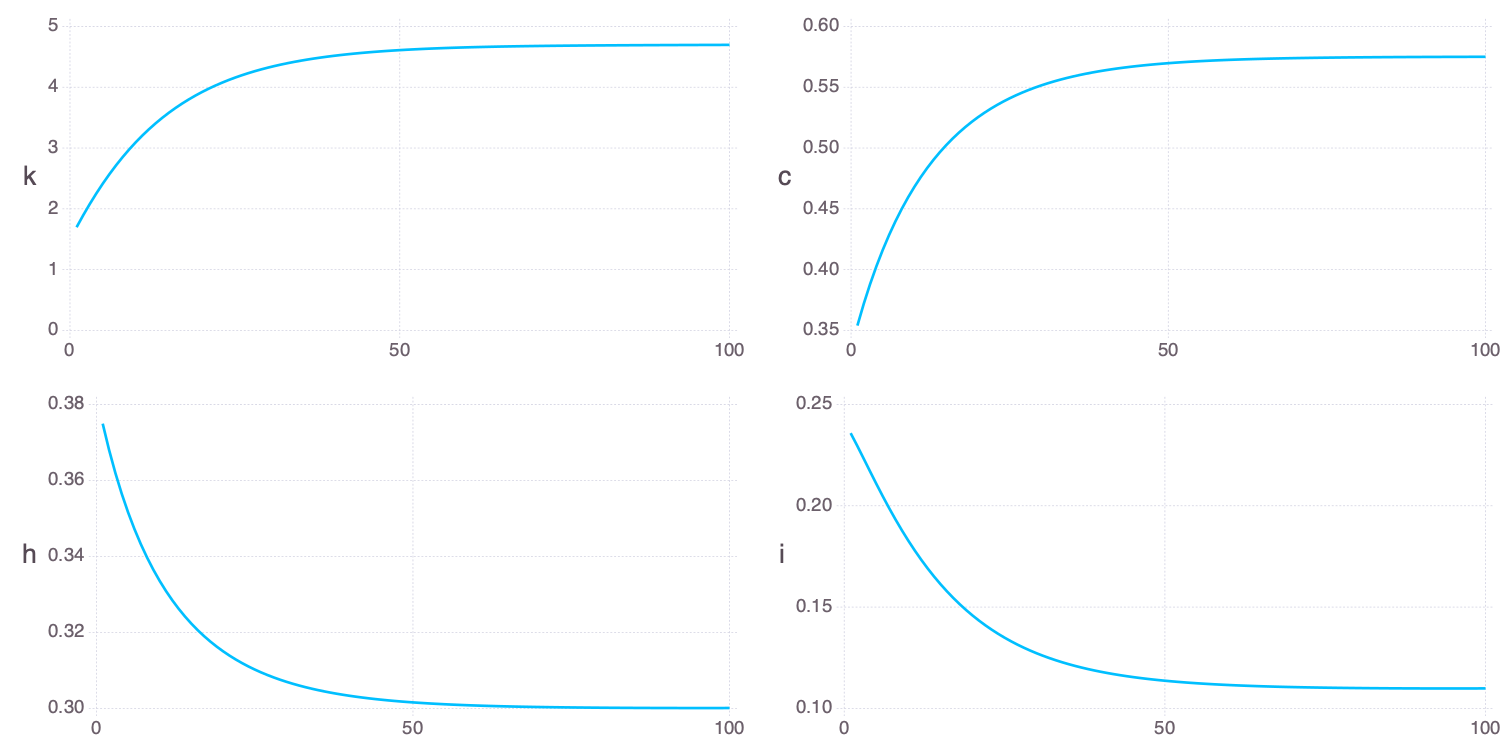

In [6]:
df = solve_transition(model,model.k̄-3,100)
gridstack([plot(df,y=:k,Geom.line) plot(df,y=:c,Geom.line);plot(df,y=:h,Geom.line) plot(df,y=:i,Geom.line)])

#### Problem 3
Next we want to solve the bellman equation.  The main difficulty is the addition of labor leisure 
choice.  As this is an intratemporal choice we can pre-solve and store the solution to this problem.
As such for a given $k$ and $k'$ let's define $U(k,k')$ as follows
$$
U(k,k') = \max_{c,h} \theta\log(c)+(1-\theta)\log(1-h)
$$
subject to
$$
c+k' = k^\alpha h^{1-\alpha} +(1-\delta)k
$$
This is the maximal utility that can be acheived if the planner enters with capital $k$ and chooses
capital $k'$.  This problem is summarized by the first order condition
$$
(1-\alpha)k^\alpha h^{-\alpha}\frac{\theta}{k^\alpha h^{1-\alpha}+(1-\delta)k-k'} = \frac{1-\theta}{1-h}.
$$
Constructing a grid over capital

In [7]:
model.kgrid = LinRange(model.k̄*0.3,model.k̄*1.7,400)

400-element LinRange{Float64}:
 1.40926,1.42574,1.44223,1.45871,1.47519,…,7.93636,7.95284,7.96933,7.98581

We fill up the indirect utility matrix (and associated hours policy) in `RBCmodelNS` via the following
function

In [8]:
"""
    construct_indirectU!(model::RBCmodelNS)

Solves for the indirect utility and hours if entering with assets
kgrid[n] and saving kgrid[n′]
"""
function construct_indirectU!(model::RBCmodelNS)
    @unpack α,β,δ,θ,kgrid = model
    N = length(kgrid)
    U = model.U = zeros(N,N)
    h = model.h = zeros(N,N)

    for n in 1:N
        for n′ in 1:N
            i = kgrid[n′] - (1-δ)*kgrid[n]
            k = kgrid[n]
            if i > k^α #output cannot cover investment
                U[n,n′] = -Inf
            else
                #minimal labor supply to ensure positive consumption
                hmin = i>0 ? ((i+0.00001)/k^α)^(1/(1-α)) : 0.00001
                f(h) = ((1-α)*k^α*h^(-α)*θ/(k^α*h^(1-α)-i) - (1-θ)/(1-h)) #optimal labor leisure choice
                if f(hmin) <= 0 
                    #investment is negative enough that negative hours solves equation impose h=0
                    h[n,n′] = hmin
                else
                    h[n,n′] = brent(f,hmin,0.999999999999)
                end
                c = k^α*h[n,n′]^(1-α) -i
                U[n,n′] = θ*log(c) + (1-θ)*log(1-h[n,n′])
            end
        end 
    end
end
construct_indirectU!(model);

We can then use this indirect utility function to construct the household bellman equation

In [9]:
"""
    RBCbellmanmap(model::RBCmodelNS,V′)

Iterates on the bellman equation for the standard neoclassical growth model

# Arguments
* `V` Vector of values for each capital level in kgrid
"""
function RBCbellmanmap(model::RBCmodelNS,V′)
    @unpack kgrid,U,h,β = model
    N = length(kgrid)
    V = zeros(N) #new value function
    n_pol = zeros(Int,N) #policy rule for grid points
    k_pol = zeros(N) #policy rule for capital
    h_pol = zeros(N)
    obj = zeros(N)
    for n in 1:N #iterate for each initial capital
        obj .= U[n,:] .+ β.*V′ #note using indirect utiltiy
        V[n],n_pol[n] = findmax(obj) #find optimal value and the choice that gives it
        k_pol[n] = kgrid[n_pol[n]] #record capital policy
        h_pol[n] = h[n,n_pol[n]] #record hours policy
    end
    return V,n_pol,k_pol,h_pol
end;

And the Howard improvement algorithm where we don't update policies

In [10]:
"""
RBCbellmanmap_howard(model::RBCmodelNS,V′,n_pol)

Iterates on the bellman equation for the standard neoclassical growth model

# Arguments
* `V` Vector of values for each capital level in kgrid
* n_pol capital policy
"""
function RBCbellmanmap_howard(model::RBCmodelNS,V′,n_pol)
    @unpack kgrid,U,h,β = model
    N = length(kgrid)
    V = zeros(N) #new value function
    for n in 1:N #iterate for each initial capital
        V[n] = U[n,n_pol[n]] + β*V′[n_pol[n]] #note using indirect utiltiy
    end
    return V
end;

We can then solve the bellman equation in the standard way

In [11]:
"""
    RBCsolve_bellman(model,V0,[,ϵ=1e-8])

Solves the bellman equation by iterating until convergence

# Arguments
* `V0` Initial vector of values for each capital level in kgrid
* `ϵ` Convergence criteria
* H=100 seems to be close to optimal for this problem
"""
function RBCsolve_bellman(model,V0,H=100,ϵ=1e-8)
    diff = 1.
    V,n_pol,k_pol,h_pol = RBCbellmanmap(model,V0)
    while diff > ϵ
        for h in 1:H
            V= RBCbellmanmap_howard(model,V,n_pol)
        end
        V_new,n_pol,k_pol,h_pol = RBCbellmanmap(model,V)
        diff = norm(V_new-V,Inf)
        println(diff)
        V = V_new 
    end
    return V,n_pol,k_pol,h_pol
end
V,n_pol,k_pol,h_pol = RBCsolve_bellman(model,zeros(length(model.kgrid)));

0.5757652686477073
0.2374874499497217
0.18153007223662598
0.3548572856692367
0.16903110485194972
0.03977278560634545
0.010957737326453554
0.0037581415402065943
0.0011247454029579274
0.00040893071453496077
0.00022124865119721449
0.00012168512788690578
0.00010697000418602443
9.868314689853719e-5
8.954833328189693e-5
8.041093664346022e-5
7.093738894425883e-5
6.0800374960479076e-5
5.0019352251240434e-5
3.8613325205716365e-5
2.6600854535985263e-5
1.4000066979491521e-5
8.286648274236086e-7
0.0


Finally we can use the constructed policy rules to simulate from an arbitrary initial capital stock

In [12]:
"""
    simulate(model::RBCmodelNS,n_0,T,n_pol,h_pol)

Simulate the path of aggregates for T periods given initial state n_0
"""
function simulate(model::RBCmodelNS,n_0,T,n_pol,h_pol)
    @unpack α,β,δ,θ,kgrid = model
    k = zeros(T+1)
    n = zeros(Int,T+1)
    c,h,y,i = zeros(T),zeros(T),zeros(T),zeros(T)
    n[1] = n_0
    k[1] = kgrid[n_0]
    #no simulate using policies
    for t in 1:T
        n[t+1] = n_pol[n[t]]
        k[t+1] = kgrid[n[t+1]]
        h[t] = h_pol[n[t]]
        y[t] = k[t]^α*h[t]^(1-α)
        i[t] = k[t+1] - (1-δ)*k[t]
        c[t] = y[t] - i[t]
    end

    return DataFrame(k=k[1:T],h=h,c=c,i=i,y=y)
end;

And compare to our solution in part 2.  Here's starting below the steady-state capital

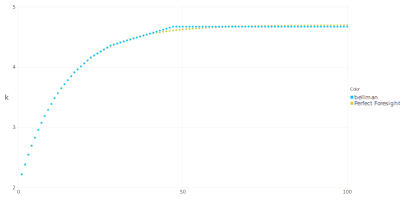

In [13]:
n0=50
df = simulate(model,n0,100,n_pol,h_pol)
df2 = solve_transition(model,model.kgrid[n0],100)
plot(layer(df,y=:k,color=["bellman"]),layer(df2,y=:k,color=["Perfect Foresight"]))

and above

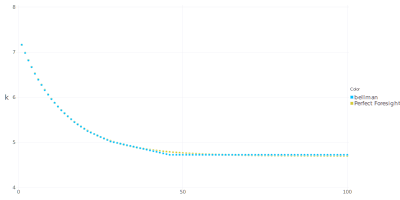

In [14]:
n0=350
df = simulate(model,n0,100,n_pol,h_pol)
df2 = solve_transition(model,model.kgrid[n0],100)
plot(layer(df,y=:k,color=["bellman"]),layer(df2,y=:k,color=["Perfect Foresight"]))

### Problem 4
Adding in the constraint that $i_t\geq0 $ is a mixed complementarity problem.  If $i_t>0$ then 
the Euler equation holds with equality
$$
\frac{\theta}{c_t} = \beta R_{t+1}\frac{\theta}{c_{t+1}}
$$
otherwise we have
$$
\frac{\theta}{c_t} > \beta R_{t+1}\frac{\theta}{c_{t+1}}
$$
and $i_t=0$. It turns out this is really easy to solve with `nlsolve` as they have a 
function `mcpsolve` which implements this exact procure.  When solving for the root of $F(x)$
lower bound $a[i]$ on $x[i]$ they implement the mixed complementarity problem by imposing that 
$F(x)[i]=0$ if $x[i]>a[i]$ and $F(x)[i]\geq0$ if $x[i]=a[i]$.  We've already set up `path_residuals!`
so that the first $T$ returns are the Euler equation at time $t$ and the first $T$ inputs are $i_t$.
All that remains to be done is using the `mcpsolve` function instead of the `nlsolve`.  We do that 
below

In [15]:
"""
    solve_transition_nri(model::RBCmodelNS,k0,T)
    
returns a path of aggregates if investment is non-reversable
"""
function solve_transition_nri(model::RBCmodelNS,k0,T)
    @unpack α,β,δ,θ,k̄,h̄,c̄ = model
    f!(F,x) = path_residuals!(model,k0,F,x,T)
    ihpath0 = [model.ī*ones(T);model.h̄*ones(T)]

                      #imposes a lower bound of 0 for i
    res = mcpsolve(f!,[zeros(T);-Inf*ones(T)],Inf*ones(2(T)),ihpath0)

    if !converged(res)
        error("Could not find root")
    end
    #Now back out aggregates
    ihpath = res.zero
    ipath,hpath = ihpath[1:T],ihpath[T+1:end]
    k = zeros(T+2)
    k[1] = k0
    for t in 1:T
        k[t+1] = (1-δ)*k[t] + ipath[t] 
    end
    k[T+2] = k̄
    h = [hpath;h̄]
    #compute path of c given guess of $k$
    c = [k[t]^α*h[t]^(1-α) + (1-δ)*k[t] - k[t+1] for t in 1:T+1]
    y = [k[t]^α*h[t]^(1-α) for t in 1:T+1]
    return DataFrame(k=k[1:T],c=c[1:T],h=h[1:T],i=ipath,y=y[1:T])
end;

The $i_t\geq0$ constraint will only bind when initial capital is high so we'll focus on that
case.  Here's the path of capital, consumption, hours and investment if capital starts out 
above the steady state

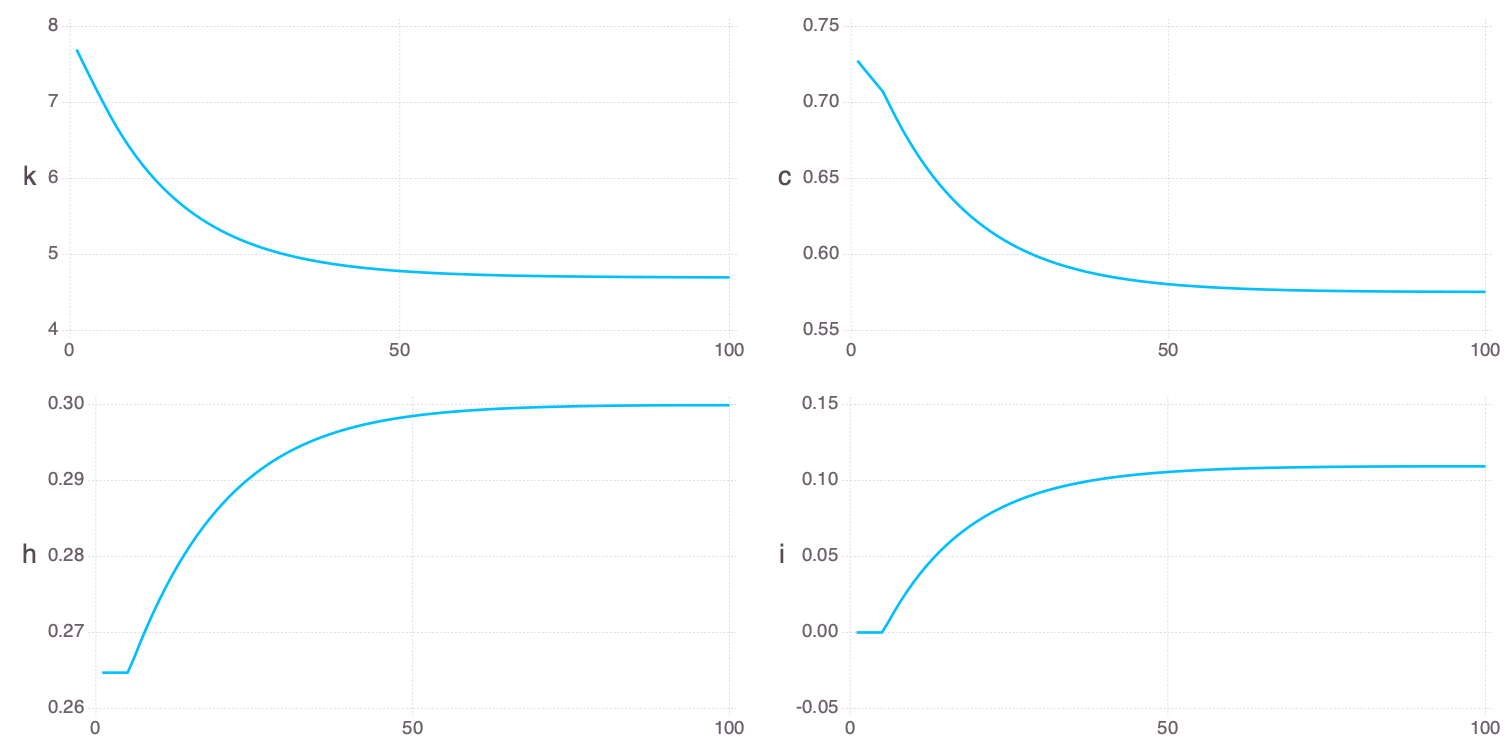

In [16]:
df = solve_transition_nri(model,model.k̄+3,100)
gridstack([plot(df,y=:k,Geom.line) plot(df,y=:c,Geom.line);plot(df,y=:h,Geom.line) plot(df,y=:i,Geom.line)])

It turns out the initial capital stock has to be quite large for the constraint to bind.

Implementing it in the bellman equation is as easy as changing how we construct $u$

In [17]:
"""
    construct_indirectU_nri!(model::RBCmodelNS)

Solves for the indirect utility and hours if entering with assets
kgrid[n] and saving kgrid[n′]
"""
function construct_indirectU_nri!(model::RBCmodelNS)
    @unpack α,β,δ,θ,kgrid = model
    N = length(kgrid)
    U = model.U = zeros(N,N)
    h = model.h = zeros(N,N)

    for n in 1:N
        for n′ in 1:N
            i = kgrid[n′] - (1-δ)*kgrid[n]
            k = kgrid[n]
            if i > k^α #output cannot cover investment
                U[n,n′] = -Inf
            elseif i <0 #cannot have negative investment
                U[n,n′] = -Inf
            else
                #minimal labor supply to ensure positive consumption
                hmin = i>0 ? ((i+0.00001)/k^α)^(1/(1-α)) : 0.00001
                f(h) = ((1-α)*k^α*h^(-α)*θ/(k^α*h^(1-α)-i) - (1-θ)/(1-h)) #optimal labor leisure choice
                if f(hmin) <= 0 
                    #investment is negative enough that negative hours solves equation impose h=0
                    h[n,n′] = hmin
                else
                    h[n,n′] = brent(f,hmin,0.999999999999)
                end
                c = k^α*h[n,n′]^(1-α) -i
                U[n,n′] = θ*log(c) + (1-θ)*log(1-h[n,n′])
            end
        end 
    end
end;

We then resolve the bellman equation with the new $U$

In [18]:
construct_indirectU_nri!(model)
V,n_pol,k_pol,h_pol = RBCsolve_bellman(model,zeros(length(model.kgrid)));

0.06517815684811623
0.0392303326628074
0.05770475756778026
0.022141647499566375
0.002484258014519014
0.0011096384727693476
0.0003217417346803586
0.000332900597406649
0.00022728036467967172
0.0002442187840223653
0.00011096648945141396
8.954832790308842e-5
7.957418647563941e-5
6.876925692012037e-5
5.714184979410675e-5
4.4700012942655576e-5
3.145153506523002e-5
1.740394937144174e-5
2.5645371444227294e-6
3.91565492918744e-7
0.0


and compare to perfect foresight policies for capital

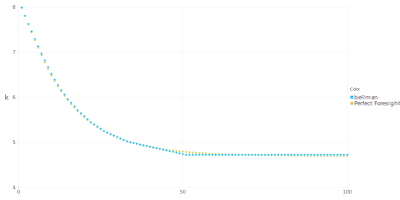

In [19]:
n0= 400
df = simulate(model,n0,100,n_pol,h_pol)
df2 = solve_transition_nri(model,model.kgrid[n0],100)
plot(layer(df,y=:k,color=["bellman"]),layer(df2,y=:k,color=["Perfect Foresight"]))

and investment

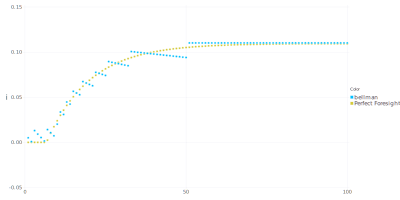

In [20]:
plot(layer(df,y=:i,color=["bellman"]),layer(df2,y=:i,color=["Perfect Foresight"]))

#### Problem 5
Estimating the data on log tfp we find $\rho=0.779$ and $\sigma=0.007$.  We adjust our 
struct and constructor appropriately

In [21]:
@with_kw mutable struct RBCmodel
    β::Float64 
    α::Float64 
    θ::Float64 
    δ::Float64
    
    #Stochastic Properties
    A::Vector{Float64}
    P::Matrix{Float64}

    #steady state
    h̄::Float64 
    ī::Float64
    k̄::Float64
    c̄::Float64

    #objects for Bellman equation
    kgrid::Vector{Float64} = zeros(0)
    U::Array{Float64,3} = zeros(0,0,0)
    h::Array{Float64,3} = zeros(0,0,0)
end

"""
    RBCmodel()

Constructs RBCmodelNS based on calibration and stores steady state
"""
function RBCmodel(ρ,σ,N)
    β = 0.98
    α = 0.3
    #first compute steady state
    h̄ = 0.3
    δ = (1/β-1)/(α/0.16 - 1)
    k̄ = (δ/0.16*0.3^(α-1))^(1/(α-1))
    c̄ = k̄^α*h̄^(1-α)-δ*k̄
    θ = (1 + (1-h̄)*(1-α)*k̄^α*h̄^(-α)/c̄)^(-1)
    ī = δ*k̄
    mc = rouwenhorst(N,ρ,σ)
    return RBCmodel(β=β,α=α,θ=θ,δ=δ,h̄=h̄,ī=ī,k̄=k̄,c̄=c̄,A=exp.(mc.state_values),P=mc.p)
end;
model = RBCmodel(0.779,0.007,25)
#Note this kgrid will, in principle, allow i>=0 to bind
model.kgrid = LinRange(model.k̄*0.3,model.k̄*1.7,400);

#### Problem 6
Next we need to adjust how we construct $U$ to find
$$
U(k,k',s) = \max_{c,h} \theta\log(c)+(1-\theta)\log(1-h)
$$
subject to
$$
c+k' = A(s)k^\alpha h^{1-\alpha} +(1-\delta)k.
$$ Our hours and indirect utility now depends on $s$.

In [22]:
"""
    construct_indirectU!(model::RBCmodel)

Solves for the indirect utility and hours if entering with assets
kgrid[n] and saving kgrid[n′] if the aggregate state is s
"""
function construct_indirectU!(model::RBCmodel)
    @unpack α,β,δ,θ,kgrid,A = model
    N = length(kgrid)
    S = length(A)
    U = model.U = zeros(N,N,S)
    h = model.h = zeros(N,N,S)

    for s in 1:S
        for n in 1:N
            for n′ in 1:N
                i = kgrid[n′] - (1-δ)*kgrid[n]
                k = kgrid[n]
                if i + 0.000001 >= A[s]*k^α  #output cannot cover investment + minimal consumption
                    U[n,n′,s] = -Inf
                else
                    #minimal labor supply to ensure positive consumption
                    hmin = i>0 ? ((i+0.000001)/(A[s]*k^α))^(1/(1-α)) : 0.000001
                    f(h) = ((1-α)*A[s]*k^α*h^(-α)*θ/(A[s]*k^α*h^(1-α)-i) - (1-θ)/(1-h)) #optimal labor leisure choice
                    if f(hmin) <= 0 
                        #investment is negative enough that negative hours solves equation impose h=0
                        h[n,n′,s] = hmin
                    else
                        h[n,n′,s] = brent(f,hmin,0.999999999999)
                    end
                    c = A[s]*k^α*h[n,n′,s]^(1-α) -i
                    U[n,n′,s] = θ*log(c) + (1-θ)*log(1-h[n,n′,s])
                end
            end 
        end
    end
end;
construct_indirectU!(model);

We then need to adjust our functions to solve the bellman equation to allow for 
stochastic productivity

In [23]:
"""
    RBCbellmanmap(model::RBCmodelNS,V′)

Iterates on the bellman equation for the standard neoclassical growth model

# Arguments
* `V` Vector of values for each capital level in kgrid
"""
function RBCbellmanmap(model::RBCmodel,V′)
    @unpack kgrid,U,h,A,P,β = model
    N = length(kgrid)
    S = length(A)
    V = zeros(S,N) #new value function
    n_pol = zeros(Int,S,N) #policy rule for grid points
    k_pol = zeros(S,N) #policy rule for capital
    h_pol = zeros(S,N)
    obj = zeros(N)

    EV′ = P*V′
    for s in 1:S
        for n in 1:N #iterate for each initial capital
            obj .= U[n,:,s] .+ β.*EV′[s,:] #note using indirect utiltiy
            V[s,n],n_pol[s,n] = findmax(obj) #find optimal value and the choice that gives it
            k_pol[s,n] = kgrid[n_pol[s,n]] #record capital policy
            h_pol[s,n] = h[n,n_pol[s,n],s] #record hours policy
        end
    end
    return V,n_pol,k_pol,h_pol
end

"""
    RBCbellmanmap_howard(model::RBCmodelNS,V′)

Iterates on the bellman equation for the standard neoclassical growth model
using the howard improvement algorithm

# Arguments
* `V′` Vector of values for each capital level in kgrid
"""
function RBCbellmanmap_howard(model::RBCmodel,V′,n_pol)
    @unpack kgrid,U,h,P,β = model
    N = length(kgrid)
    S = size(P,1)
    V = zeros(S,N) #new value function
    EV′ = P*V′
    for s in 1:S
        for n in 1:N #iterate for each initial capital
            V[s,n] = U[n,n_pol[s,n],s] + β*EV′[s,n_pol[s,n]] #note using indirect utiltiy
        end
    end
    return V
end
V,n_pol,k_pol,h_pol = RBCsolve_bellman(model,zeros(25,400));

0.5907310332003171
0.2420460756313183
0.1555493820167122
0.3299471531188871
0.18613748850549072
0.04679932085019445
0.014371393700773893
0.0033368273111840097
0.0010004389851410167
0.00038605174527361896
0.00014301946419692513
2.8484085365931833e-5
2.2300039219658174e-6
5.395435209720745e-10


Finally we need to adjust the code which simulates the model to allow for 
stochastic productivity.

In [24]:
"""
    simulate(model::RBCmodel,n_0,s_0,T,n_pol,h_pol)

Simulate the path of aggregates for T periods given initial state n_0,s_0
"""
function simulate(model::RBCmodel,n_0,s_0,T,n_pol,h_pol)
    @unpack α,β,δ,θ,kgrid,P,A = model
    k = zeros(T+1)
    n = zeros(Int,T+1)
    c,h,y,i = zeros(T),zeros(T),zeros(T),zeros(T)
    s = simulate_indices(MarkovChain(P),T,init=s_0)
    n[1] = n_0
    k[1] = kgrid[n_0]
    #no simulate using policies
    for t in 1:T
        n[t+1] = n_pol[s[t],n[t]]
        k[t+1] = kgrid[n[t+1]]
        h[t] = h_pol[s[t],n[t]]
        y[t] = A[s[t]]*k[t]^α*h[t]^(1-α)
        i[t] = k[t+1] - (1-δ)*k[t]
        c[t] = y[t] - i[t]
    end

    return DataFrame(k=k[1:T],h=h,c=c,i=i,y=y)
end
df = simulate(model,200,13,10000,n_pol,h_pol);

We then drop the first $3000$ periods and compute the standard deviations, autocorrelations,
and cross-correlations of output,consumptions,hours and investment.

In [25]:
using Statistics,StatsBase
df = select!(df,Not(:k)) #drop k
df = last(df,7000) #drop first 3000
describe(df,:std,
                 (x->autocor(x,[1])[1])=>:autocorr,
                 (x->cor(x,df.h))=>:cor_h,
                 (x->cor(x,df.c))=>:cor_c,
                 (x->cor(x,df.i))=>:cor_i,
                 (x->cor(x,df.y))=>:cor_y,
                 )

,variable,std,autocorr,cor_h,cor_c,cor_i,cor_y
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64
1,h,0.00351398,0.591975,1.0,0.0619028,0.994765,0.851554
2,c,0.00617075,0.846667,0.0619028,1.0,0.16278,0.57587
3,i,0.0115944,0.622357,0.994765,0.16278,1.0,0.900378
4,y,0.0139929,0.781093,0.851554,0.57587,0.900378,1.0


As a final note if we count the number of periods with negative investment we find

In [26]:
sum(df.i.<=0)

0

So we should not expect the $i_t\geq0$ constraint to bind
#### Problem 7
Again, implementing $i_t\geq0$ is as easy as changing how we construct $U$

In [27]:
"""
    construct_indirectU_nri!(model::RBCmodel)

Solves for the indirect utility and hours if entering with assets
kgrid[n] and saving kgrid[n′] if the aggregate state is s. 
Investment is nonreversible
"""
function construct_indirectU_nri!(model::RBCmodel)
    @unpack α,β,δ,θ,kgrid,A = model
    N = length(kgrid)
    S = length(A)
    U = model.U = zeros(N,N,S)
    h = model.h = zeros(N,N,S)

    for s in 1:S
        for n in 1:N
            for n′ in 1:N
                i = kgrid[n′] - (1-δ)*kgrid[n]
                k = kgrid[n]
                if i + 0.000001 >= A[s]*k^α  #output cannot cover investment + minimal consumption
                    U[n,n′,s] = -Inf
                elseif i < 0 #Investment cannot be negative
                    U[n,n′,s] = -Inf
                else
                    #minimal labor supply to ensure positive consumption
                    hmin = i>0 ? ((i+0.000001)/(A[s]*k^α))^(1/(1-α)) : 0.000001
                    f(h) = ((1-α)*A[s]*k^α*h^(-α)*θ/(A[s]*k^α*h^(1-α)-i) - (1-θ)/(1-h)) #optimal labor leisure choice
                    if f(hmin) <= 0 
                        #investment is negative enough that negative hours solves equation impose h=0
                        h[n,n′,s] = hmin
                    else
                        h[n,n′,s] = brent(f,hmin,0.999999999999)
                    end
                    c = A[s]*k^α*h[n,n′,s]^(1-α) -i
                    U[n,n′,s] = θ*log(c) + (1-θ)*log(1-h[n,n′,s])
                end
            end 
        end
    end
end
construct_indirectU_nri!(model);

We then solve and simulate to get essentially the same moments

In [28]:
V,n_pol,k_pol,h_pol = RBCsolve_bellman(model,zeros(25,400))

df = simulate(model,200,13,10000,n_pol,h_pol)
df = select!(df,Not(:k)) #drop k
df = last(df,7000) #drop first 3000
describe(df,:std,
                 (x->autocor(x,[1])[1])=>:autocorr,
                 (x->cor(x,df.h))=>:cor_h,
                 (x->cor(x,df.c))=>:cor_c,
                 (x->cor(x,df.i))=>:cor_i,
                 (x->cor(x,df.y))=>:cor_y,
                 )

0.08250321550008266
0.04381488233316588
0.054892636021484975
0.030235354720677066
0.020549002063479094
0.0019193951039149226
0.0006525925558520385
0.00020568261592401882
8.053560389953418e-5
3.0795243930015204e-5
3.635218348563285e-9


,variable,std,autocorr,cor_h,cor_c,cor_i,cor_y
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64
1,h,0.00332892,0.540951,1.0,0.0456702,0.994467,0.842687
2,c,0.00600235,0.838602,0.0456702,1.0,0.14962,0.57623
3,i,0.0109633,0.575174,0.994467,0.14962,1.0,0.894304
4,y,0.0132633,0.759642,0.842687,0.57623,0.894304,1.0
